# Abstract

In [ ]:
# code

In [1]:
# imports

# misc
import datetime
import os, sys, shutil

# basics
import numpy as np
from numpy import loadtxt
import pandas as pd
from tqdm import tqdm

# charting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 


# for darksky api
import json
import requests

In [2]:
# load the data
df_train = pd.read_csv('source_data/dengue_features_train.csv') 

In [3]:
df_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [4]:
train_labels = pd.read_csv('source_data/dengue_labels_train.csv')

In [5]:
train_labels.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [6]:
train_labels['year'].unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

In [8]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 4 columns):
city           1456 non-null object
year           1456 non-null int64
weekofyear     1456 non-null int64
total_cases    1456 non-null int64
dtypes: int64(3), object(1)
memory usage: 45.6+ KB


In [9]:
df_train['total_cases'] = train_labels['total_cases']

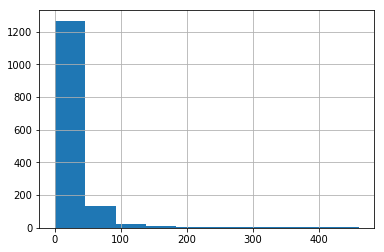

In [10]:
df_train['total_cases'].hist()

In [18]:
df_train.iloc[:,4:12].describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k
count,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000
mean,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356
std,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810
min,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857
25%,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929
50%,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714
75%,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000
max,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000


In [23]:
df_train.iloc[:,12:24].describe()

,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1446.000000,1446.000000,1446.000000,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000
mean,303.427109,295.719156,40.151819,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360
std,3.234601,2.565364,43.434399,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314
min,297.800000,286.900000,0.000000,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,301.000000,293.900000,13.055000,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000
50%,302.400000,296.200000,27.245000,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000
75%,305.500000,297.900000,52.200000,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000
max,314.000000,299.900000,570.500000,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000


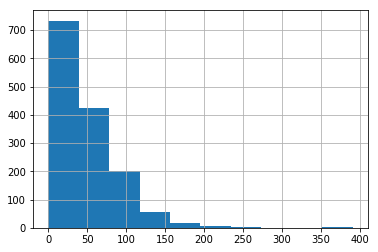

In [28]:
df_train.precipitation_amt_mm.hist()

In [ ]:
# get darksky.net historical weather information
# my 
# request format:  https://api.darksky.net/forecast/[key]/[latitude],[longitude],[time]







In [48]:
# SF: 37.7648, -122.463
# this gets current SF weather forecast
target = 'https://api.darksky.net/forecast/9501b92a37587155d222ae11b77c65a3/37.7648, -122.463'

# target = 'https://api.darksky.net/forecast/9501b92a37587155d222ae11b77c65a3/42.3601,-71.0589,255657600?exclude=currently,flags'
req = requests.get(url=target)
# req.text
json_data = json.loads(req.text)

print(json.dumps(json_data, indent=4, sort_keys=True))



{
    "currently": {
        "apparentTemperature": 61.22,
        "cloudCover": 0.15,
        "dewPoint": 55.21,
        "humidity": 0.81,
        "icon": "partly-cloudy-night",
        "nearestStormBearing": 152,
        "nearestStormDistance": 2,
        "ozone": 311.1,
        "precipIntensity": 0,
        "precipProbability": 0,
        "pressure": 1014.41,
        "summary": "Partly Cloudy",
        "temperature": 61.22,
        "time": 1568173657,
        "uvIndex": 0,
        "visibility": 8.799,
        "windBearing": 292,
        "windGust": 12.42,
        "windSpeed": 6.04
    },
    "daily": {
        "data": [
            {
                "apparentTemperatureHigh": 64.85,
                "apparentTemperatureHighTime": 1568142000,
                "apparentTemperatureLow": 57.63,
                "apparentTemperatureLowTime": 1568210400,
                "apparentTemperatureMax": 64.85,
                "apparentTemperatureMaxTime": 1568142000,
                "apparentTempera